In [1]:
import pandas as pd
import collections
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import statistics
import scipy, scipy.stats
from scipy.stats import binom
from scipy.stats import skewnorm
import math

In [2]:
### LOAD DATAFRAMES

df_all = pd.read_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_allprojects.pkl')
df_success = pd.read_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_successprojects.pkl')
df_fail = pd.read_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_failprojects.pkl')

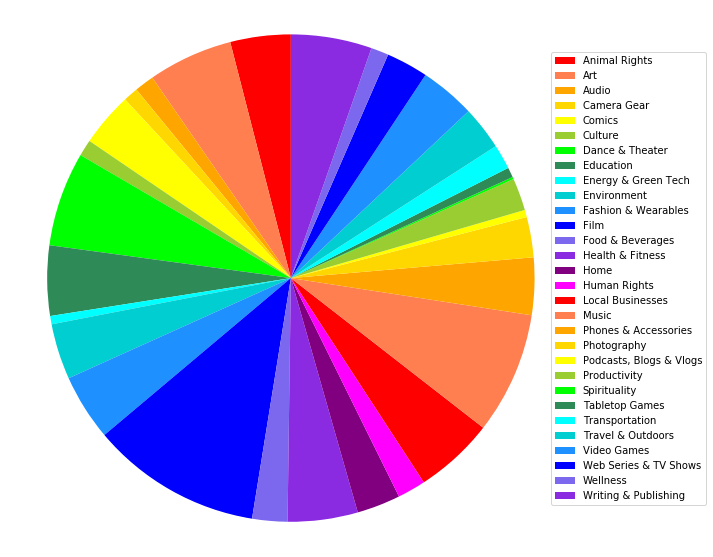

{'Animal Rights': 1262, 'Art': 1772, 'Audio': 409, 'Camera Gear': 310, 'Comics': 1129, 'Culture': 344, 'Dance & Theater': 1975, 'Education': 1464, 'Energy & Green Tech': 173, 'Environment': 1166, 'Fashion & Wearables': 1386, 'Film': 3567, 'Food & Beverages': 735, 'Health & Fitness': 1464, 'Home': 910, 'Human Rights': 589, 'Local Businesses': 1668, 'Music': 2548, 'Phones & Accessories': 1198, 'Photography': 842, 'Podcasts, Blogs & Vlogs': 151, 'Productivity': 677, 'Spirituality': 46, 'Tabletop Games': 208, 'Transportation': 517, 'Travel & Outdoors': 913, 'Video Games': 1161, 'Web Series & TV Shows': 877, 'Wellness': 368, 'Writing & Publishing': 1691}


In [3]:
### ALL CATEGORIES PIE CHART

fig = plt.figure(figsize=(10, 8))
category_freq = df_all['category'].value_counts().to_dict()
category_freq = dict(sorted(category_freq.items()))
colors = ['red','coral','orange','gold','yellow','yellowgreen','lime','seagreen','cyan','darkturquoise','dodgerblue','blue','mediumslateblue','blueviolet','purple','magenta']
patches, texts = plt.pie(category_freq.values(), colors = colors, startangle=90)
plt.legend(patches, category_freq.keys(), loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()

print(category_freq)

In [4]:
from datetime import timedelta
from datetime import datetime

In [5]:
### COMPETITION VS. NON-COMPETITION

# per subcategory
category_multi_projects = []
category_single_projects = []

category_all_freq = df_all['category'].value_counts().to_dict()
category_success_freq = df_success['category'].value_counts().to_dict()

# creating list of categories with more than one project
for i in category_all_freq:
    if category_all_freq[i] > 1:
        category_multi_projects.append(i)
    else:
        category_single_projects.append(i)
        
category_success_rate = {}
for j in list(category_all_freq.keys()):
    if j in category_success_freq.keys():
        category_success_rate[j] = category_success_freq[j] / category_all_freq[j]
    else: # no successes in these categories
        category_success_rate[j] = 0

df_all_multi = df_all.loc[df_all['category'].isin(category_multi_projects)]
df_all_single = df_all.loc[df_all['category'].isin(category_single_projects)]

df_all_c = pd.DataFrame() # competition
df_all_nc = pd.DataFrame() # no competition
for j in category_multi_projects:
    temp = df_all_multi.loc[df_all_multi['category'] == j]
    temp['overlap'] = (temp['deadline'].shift() - temp['created_at']) > timedelta(0)
    temp1 = temp.loc[temp['overlap'] == True]
    temp2 = temp.loc[temp['overlap'] == False]
    if len(temp1) > 0:
        df_all_c = df_all_c.append(temp1, sort = True) # overlapping projects within category
    if len(temp2) > 0:
        df_all_nc = df_all_nc.append(temp2, sort = True) # non-overlapping projects within category

df_all_nc = df_all_nc.append(df_all_single, sort = True) # single + non-overlapping projects

# remove duplicates
df_all_c = df_all_c.drop_duplicates('id')
df_all_nc = df_all_nc.drop_duplicates('id')
            
df_success_c = df_all_c.loc[df_all_c['state'] == 'successful'] # successful subset for competing projects
df_fail_c = df_all_c.loc[~(df_all_c['state'] == 'successful')] # failed subset for competing projects
df_fail_c = df_fail_c.loc[df_all_c['P/G'] <= 1] # remove bad data
df_success_nc = df_all_nc.loc[df_all_nc['state'] == 'successful'] # successful subset for non-competing projects
df_fail_nc = df_all_nc.loc[~(df_all_nc['state'] == 'successful')] # failed subset for non-competing projects
df_fail_nc = df_fail_nc.loc[df_all_nc['P/G'] <= 1] # remove bad data

category_all_c_freq = df_all_c['category'].value_counts().to_dict()
category_success_c_freq = df_success_c['category'].value_counts().to_dict()
category_fail_c_freq = df_fail_c['category'].value_counts().to_dict()
category_all_nc_freq = df_all_nc['category'].value_counts().to_dict()
category_success_nc_freq = df_success_nc['category'].value_counts().to_dict()
category_fail_nc_freq = df_fail_nc['category'].value_counts().to_dict()

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of total projects: 31520
Number of competitive projects: 18246
Number of successful competitive projects: 4480
Number of failed competitive projects: 13766
Number of non-competitive projects: 13274
Number of failed non-competitive projects: 3669
Number of success non-competitive projects: 9605

Mean duration for all competitive projects (months): 
1.3678
Median duration for all competitive projects (months): 
1.3471
Mean duration for all non-competitive projects (months): 
1.3794
Median duration for all non-competitive projects (months): 
1.3471


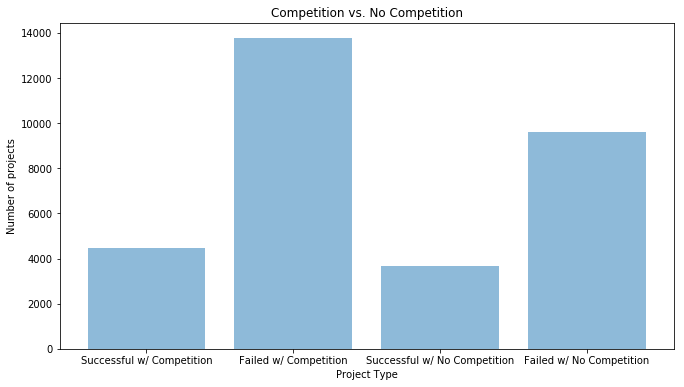

In [6]:
print('Number of total projects: ' + str(len(df_all)))
print('Number of competitive projects: ' + str(len(df_all_c)))
print('Number of successful competitive projects: ' + str(len(df_success_c)))
print('Number of failed competitive projects: ' + str(len(df_fail_c)))
print('Number of non-competitive projects: ' + str(len(df_all_nc)))
print('Number of failed non-competitive projects: ' + str(len(df_success_nc)))
print('Number of success non-competitive projects: ' + str(len(df_fail_nc)))

print()
print('Mean duration for all competitive projects (months): ')
print(round(np.mean(list(df_all_c['duration'])), 4))
print('Median duration for all competitive projects (months): ')
print(round(statistics.median(list(df_all_c['duration'])), 4))
print('Mean duration for all non-competitive projects (months): ')
print(round(np.mean(list(df_all_nc['duration'])), 4))
print('Median duration for all non-competitive projects (months): ')
print(round(statistics.median(list(df_all_nc['duration'])), 4))

objects = ('Successful w/ Competition', 'Failed w/ Competition', 
           'Successful w/ No Competition', 'Failed w/ No Competition')
fig = plt.figure(figsize = (11,6))
y_pos = np.arange(len(objects))
performance = [len(df_success_c), len(df_fail_c), len(df_success_nc), len(df_fail_nc)]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Project Type')
plt.ylabel('Number of projects')
plt.title('Competition vs. No Competition')
plt.show()

Competition


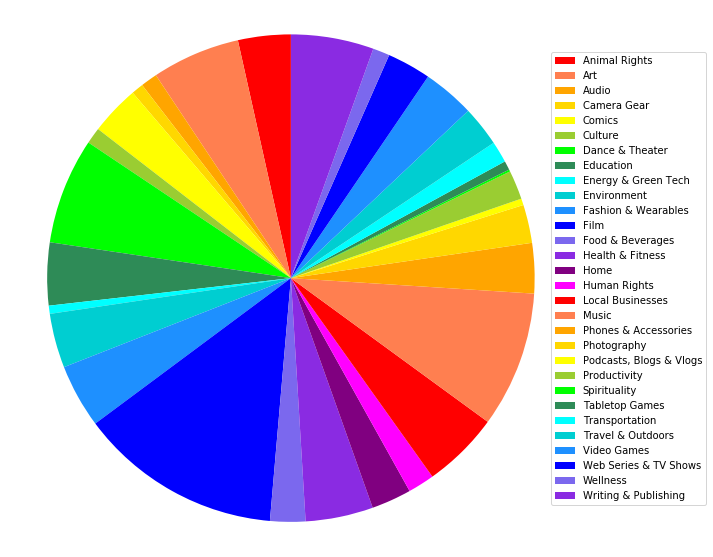

{'Animal Rights': 595, 'Art': 997, 'Audio': 188, 'Camera Gear': 135, 'Comics': 560, 'Culture': 184, 'Dance & Theater': 1199, 'Education': 708, 'Energy & Green Tech': 92, 'Environment': 614, 'Fashion & Wearables': 720, 'Film': 2291, 'Food & Beverages': 398, 'Health & Fitness': 764, 'Home': 451, 'Human Rights': 300, 'Local Businesses': 870, 'Music': 1537, 'Phones & Accessories': 567, 'Photography': 432, 'Podcasts, Blogs & Vlogs': 74, 'Productivity': 328, 'Spirituality': 23, 'Tabletop Games': 102, 'Transportation': 242, 'Travel & Outdoors': 456, 'Video Games': 587, 'Web Series & TV Shows': 495, 'Wellness': 190, 'Writing & Publishing': 935}

No Competition


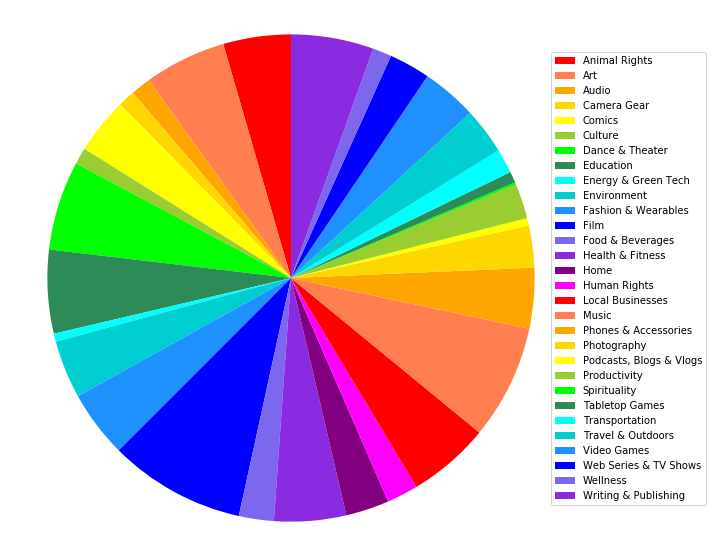

{'Animal Rights': 551, 'Art': 667, 'Audio': 164, 'Camera Gear': 138, 'Comics': 459, 'Culture': 135, 'Dance & Theater': 728, 'Education': 681, 'Energy & Green Tech': 66, 'Environment': 474, 'Fashion & Wearables': 545, 'Film': 1113, 'Food & Beverages': 285, 'Health & Fitness': 586, 'Home': 354, 'Human Rights': 255, 'Local Businesses': 671, 'Music': 933, 'Phones & Accessories': 494, 'Photography': 342, 'Podcasts, Blogs & Vlogs': 61, 'Productivity': 284, 'Spirituality': 19, 'Tabletop Games': 90, 'Transportation': 199, 'Travel & Outdoors': 378, 'Video Games': 453, 'Web Series & TV Shows': 335, 'Wellness': 154, 'Writing & Publishing': 673}


In [7]:
### ALL CATEGORIES PIE CHART COMPETITION VS NON-COMPETITION

print('Competition')
fig1 = plt.figure(figsize=(10, 8))
category_c_freq = df_all_c['category'].value_counts().to_dict()
category_c_freq = dict(sorted(category_c_freq.items()))
colors = ['red','coral','orange','gold','yellow','yellowgreen','lime','seagreen','cyan','darkturquoise','dodgerblue','blue','mediumslateblue','blueviolet','purple','magenta']
patches, texts = plt.pie(category_c_freq.values(), colors = colors, startangle=90)
plt.legend(patches, category_c_freq.keys(), loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()
print(category_c_freq)

print()
print('No Competition')
fig2 = plt.figure(figsize=(10, 8))
category_nc_freq = df_all_nc['category'].value_counts().to_dict()
category_nc_freq = dict(sorted(category_nc_freq.items()))
colors = ['red','coral','orange','gold','yellow','yellowgreen','lime','seagreen','cyan','darkturquoise','dodgerblue','blue','mediumslateblue','blueviolet','purple','magenta']
patches, texts = plt.pie(category_nc_freq.values(), colors = colors, startangle=90)
plt.legend(patches, category_nc_freq.keys(), loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()
print(category_nc_freq)


In [8]:
from collections import namedtuple

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Duration (months)')

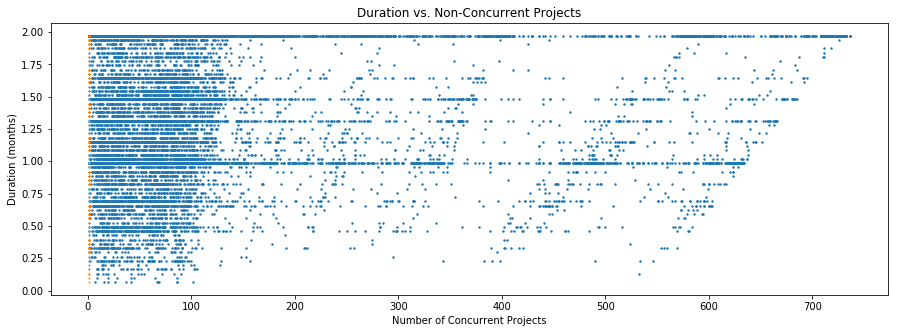

In [12]:
### NUMBER OF CONCURRENT PROJECTS VS. DURATION

Range = namedtuple('Range', ['start', 'end'])

concurrent = []
curr_duration = []

for j in list(category_all_c_freq.keys()):
    count = 0
    temp = df_all_c.loc[df_all_c['category'] == j]
    temp.sort_values(['deadline'], ascending = [True], inplace = True)

    lst_start = list(temp['created_at'])
    lst_end = list(temp['deadline'])
    for i in range(len(lst_start)):
        r1 = Range(start=lst_start[i], end=lst_end[i])
        count_concurrent = 1
        curr_duration.append(lst_end[i] - lst_start[i])
        for j in range(len(lst_start)):
            if i != j:
                r2 = Range(start=lst_start[j], end=lst_end[j])
                latest_start = max(r1.start, r2.start)
                earliest_end = min(r1.end, r2.end)
                delta = ((earliest_end - latest_start).days/30) + 1
                overlap = max(0, delta)
                if overlap > 0:
                    count_concurrent += 1
        concurrent.append(count_concurrent)  
    
months = []
for i in curr_duration:
    months.append(i/ np.timedelta64(1,'M'))

fig1 = plt.figure(figsize = (15,5))
plt.scatter(concurrent, months, s = 2)
plt.title('Duration vs. Number of Concurrent Projects')
plt.xlabel('Number of concurrent projects')
plt.ylabel('Duration (Months)')

months1 = []
lst_start = list(df_all_nc['created_at'])
lst_end = list(df_all_nc['deadline'])

for i in range(len(lst_start)):
    months1.append((lst_end[i] - lst_start[i])/ np.timedelta64(1,'M'))
plt.scatter([1] * len(months1), months1, s = 0.1)
plt.title('Duration vs. Non-Concurrent Projects')
plt.xlabel('Number of Concurrent Projects')
plt.ylabel('Duration (months)')

In [13]:
def mean_confidence_interval(data, confidence):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

Probability of success conditional on competition: 0.24553326756549382
Probability of success conditional on no competition: 0.27640500226005726


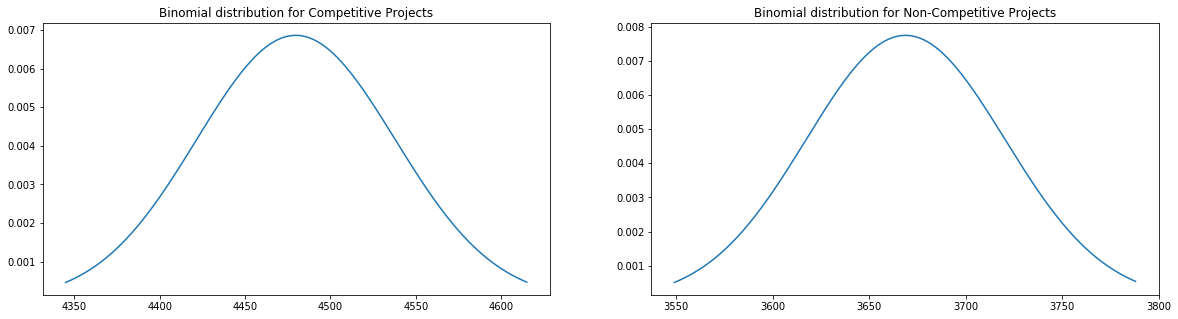

In [14]:
# probability of success conditional on competition
success_rate_c = len(df_success_c) / len(df_all_c)
print("Probability of success conditional on competition: " + str(success_rate_c))

# probability of success conditional on no competition
success_rate_nc = len(df_success_nc) / len(df_all_nc)
print("Probability of success conditional on no competition: " + str(success_rate_nc))

# binomial: 1 for success, 0 for failure
binomial_c = [1]*len(df_success_c) + [0]*len(df_fail_c)
binomial_nc = [1]*len(df_success_nc) + [0]*len(df_fail_nc)

fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
s1, n1, p1 = len(df_success_c), len(binomial_c), np.mean(binomial_c)
mean1, var1, skew1, kurt1 = binom.stats(n1, p1, moments = 'mvsk')
x1 = np.arange(binom.ppf(0.01, n1, p1), binom.ppf(0.99, n1, p1))
plt.plot(x1, binom.pmf(x1, n1, p1))
plt.title('Binomial distribution for Competitive Projects')
s2, n2, p2 = len(df_success_nc), len(binomial_nc), np.mean(binomial_nc)
mean2, var2, skew2, kurt2 = binom.stats(n2, p2, moments = 'mvsk')
x2 = np.arange(binom.ppf(0.01, n2, p2), binom.ppf(0.99, n2, p2))
plt.subplot(1,2,2)
plt.plot(x2, binom.pmf(x2, n2, p2))
plt.title('Binomial distribution for Non-Competitive Projects')
plt.show()


All competitive vs. non-competitive projects goal confidence interval ($)
(11366.728323352827, 11183.285143717201, 11550.171502988453)
(12430.963150392241, 12203.106684758994, 12658.819616025488)

Successful competitive vs. non-competitive projects goal confidence interval ($)
(8428.466924915383, 8121.002603648601, 8735.931246182166)
(9785.67371994749, 9410.016237827238, 10161.331202067742)

Failed competitive vs. non-competitive projects goal confidence interval ($)
(12273.760767953445, 12055.574968555848, 12491.946567351042)
(13393.473834485692, 13117.010342574535, 13669.93732639685)


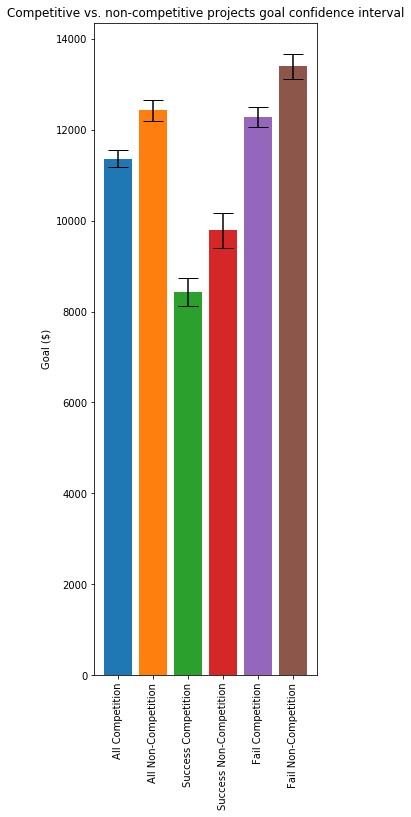

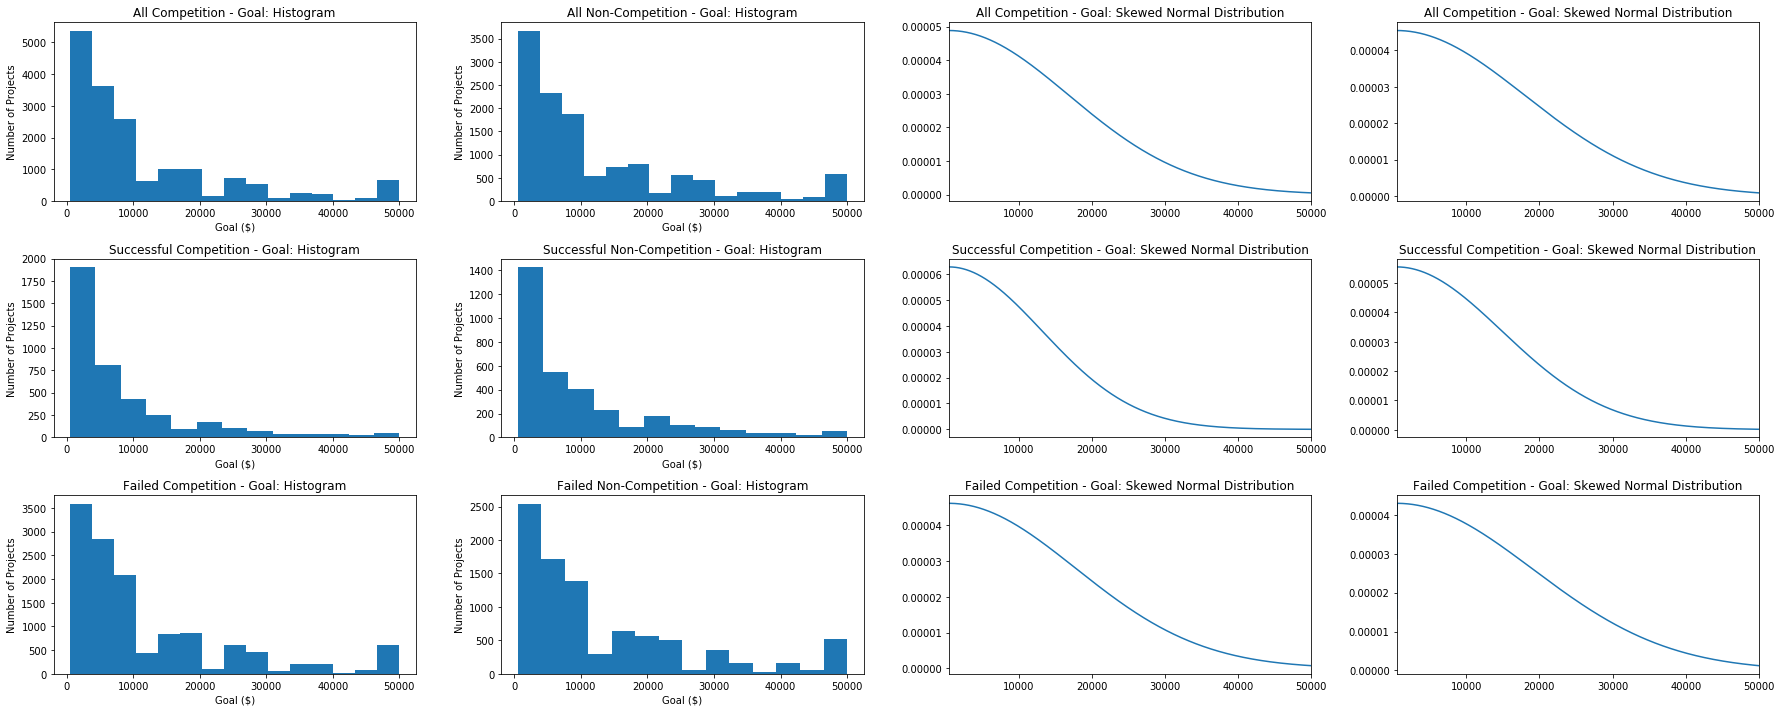

In [13]:
### GOAL CI

print('All competitive vs. non-competitive projects goal confidence interval ($)')
x2, x1, x3 = mean_confidence_interval(list(df_all_c['goal']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_all_nc['goal']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

print()
print('Successful competitive vs. non-competitive projects goal confidence interval ($)')
x5, x4, x6 = mean_confidence_interval(list(df_success_c['goal']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df_success_nc['goal']), 0.95)
print((x5, x4, x6))
print((y5, y4, y6))

print()
print('Failed competitive vs. non-competitive projects goal confidence interval ($)')
x8, x7, x9 = mean_confidence_interval(list(df_fail_c['goal']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df_fail_nc['goal']), 0.95)
print((x8, x7, x9))
print((y8, y7, y9))

fig1 = plt.figure(figsize = (4,12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects goal confidence interval')
plt.ylabel('Goal ($)')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (25,10))

plt.subplot(3,4,1)
new_lst = [i for i in list(df_all_c['goal'])]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - Goal: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_all_nc['goal'])]
plt.subplot(3,4,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - Goal: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - Goal: Skewed Normal Distribution')
plt.xlim([500,50000])
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Competition - Goal: Skewed Normal Distribution')
plt.xlim([500,50000])

plt.subplot(3,4,5)
new_lst = [i for i in list(df_success_c['goal'])]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - Goal: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_success_nc['goal'])]
plt.subplot(3,4,6)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - Goal: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,7)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - Goal: Skewed Normal Distribution')
plt.xlim([500,50000])
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,8)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Competition - Goal: Skewed Normal Distribution')
plt.xlim([500,50000])

plt.subplot(3,4,9)
new_lst = [i for i in list(df_fail_c['goal'])]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - Goal: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_fail_nc['goal'])]
plt.subplot(3,4,10)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - Goal: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,11)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - Goal: Skewed Normal Distribution')
plt.xlim([500,50000])
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,12)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Failed Competition - Goal: Skewed Normal Distribution')
plt.xlim([500,50000])

plt.tight_layout()
plt.show()

All competitive vs. non-competitive projects pledged confidence interval ($)
(5406.0373370905245, 5087.782834871836, 5724.291839309213)
(8142.691788068691, 7593.825830865283, 8691.557745272097)

Successful competitive vs. non-competitive projects pledged confidence interval ($)
(16338.101791936288, 15061.009624034114, 17615.19395983846)
(24237.532031726663, 22295.167385341927, 26179.8966781114)

Failed competitive vs. non-competitive projects pledged confidence interval ($)
(2031.341963736939, 1968.8960730813965, 2093.7878543924817)
(2286.4495504495503, 2206.268420683862, 2366.6306802152385)


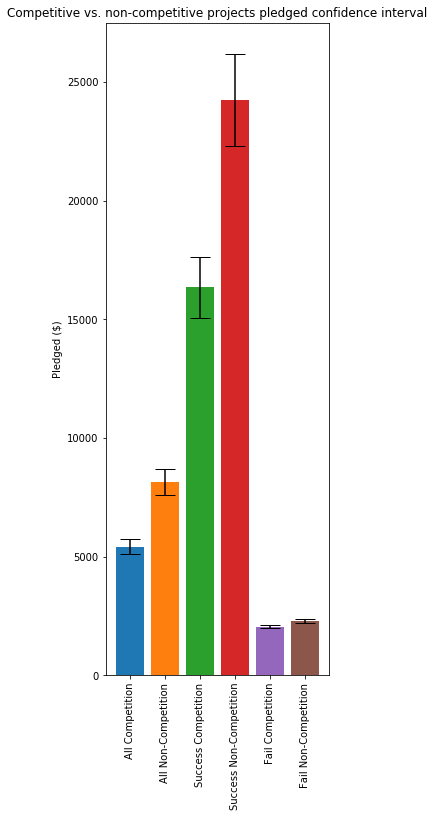

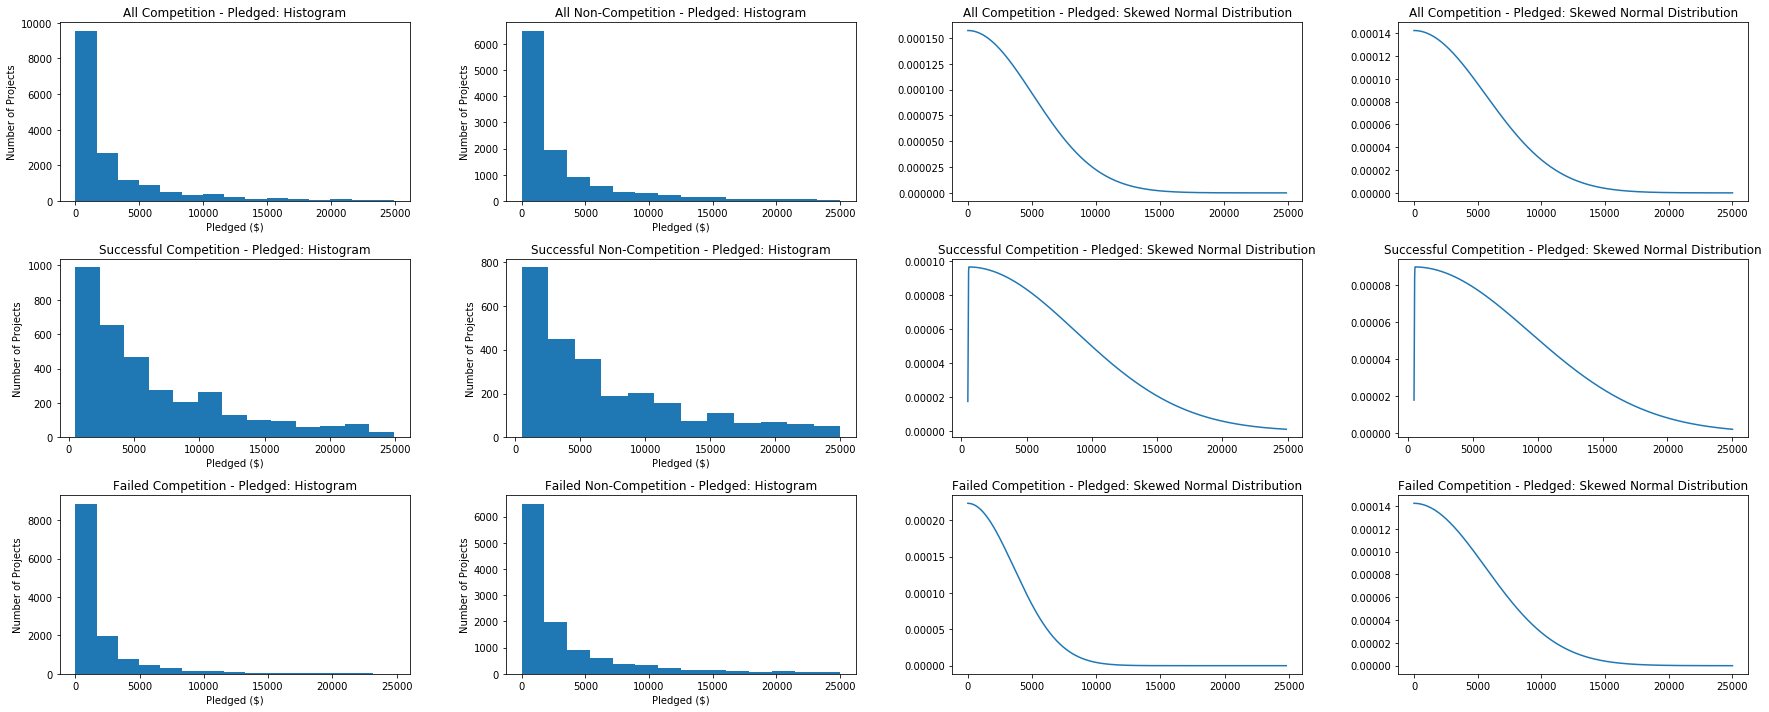

In [14]:
### PLEDGED CI

print('All competitive vs. non-competitive projects pledged confidence interval ($)')
x2, x1, x3 = mean_confidence_interval(list(df_all_c['usd_pledged']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_all_nc['usd_pledged']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

print()
print('Successful competitive vs. non-competitive projects pledged confidence interval ($)')
x5, x4, x6 = mean_confidence_interval(list(df_success_c['usd_pledged']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df_success_nc['usd_pledged']), 0.95)
print((x5, x4, x6))
print((y5, y4, y6))

print()
print('Failed competitive vs. non-competitive projects pledged confidence interval ($)')
x8, x7, x9 = mean_confidence_interval(list(df_fail_c['usd_pledged']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df_fail_nc['usd_pledged']), 0.95)
print((x8, x7, x9))
print((y8, y7, y9))

fig1 = plt.figure(figsize = (4,12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects pledged confidence interval')
plt.ylabel('Pledged ($)')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (25,10))

plt.subplot(3,4,1)
new_lst = [i for i in list(df_all_c['usd_pledged']) if i <= 25000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - Pledged: Histogram')
plt.xlabel('Pledged ($)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_all_nc['usd_pledged']) if i <= 25000]
plt.subplot(3,4,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - Pledged: Histogram')
plt.xlabel('Pledged ($)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - Pledged: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Competition - Pledged: Skewed Normal Distribution')

plt.subplot(3,4,5)
new_lst = [i for i in list(df_success_c['usd_pledged']) if i <= 25000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - Pledged: Histogram')
plt.xlabel('Pledged ($)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_success_nc['usd_pledged']) if i <= 25000]
plt.subplot(3,4,6)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - Pledged: Histogram')
plt.xlabel('Pledged ($)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,7)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - Pledged: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,8)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Competition - Pledged: Skewed Normal Distribution')

plt.subplot(3,4,9)
new_lst = [i for i in list(df_fail_c['usd_pledged']) if i <= 25000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - Pledged: Histogram')
plt.xlabel('Pledged ($)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_all_nc['usd_pledged']) if i <= 25000]
plt.subplot(3,4,10)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - Pledged: Histogram')
plt.xlabel('Pledged ($)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,11)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - Pledged: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,12)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Failed Competition - Pledged: Skewed Normal Distribution')

plt.tight_layout()
plt.show()

All competitive vs. non-competitive projects P/G confidence interval
(0.5718505575133555, 0.5547573008784689, 0.588943814148242)
(0.7430634685670704, 0.7140330223101744, 0.7720939148239664)

Successful competitive vs. non-competitive projects P/G confidence interval
(1.6931130939974248, 1.6339301895859948, 1.7522959984088549)
(2.148757252006507, 2.0565357329731087, 2.2409787710399054)

Failed competitive vs. non-competitive projects P/G confidence interval
(0.22572018938236352, 0.22160662270810702, 0.22983375605662001)
(0.23159002843892387, 0.2266617128714079, 0.23651834400643984)


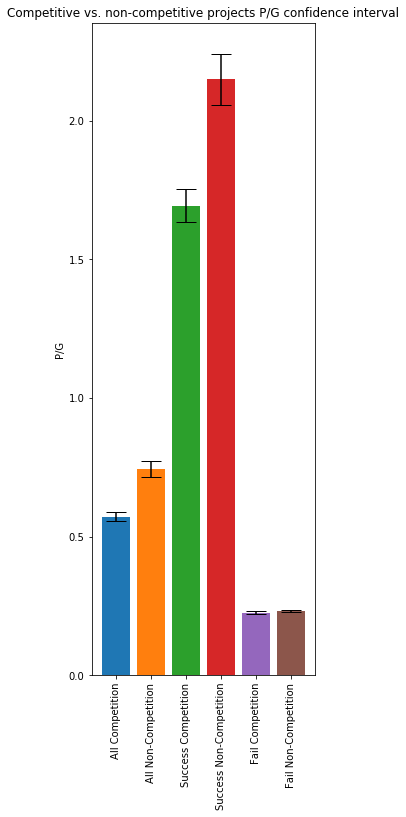

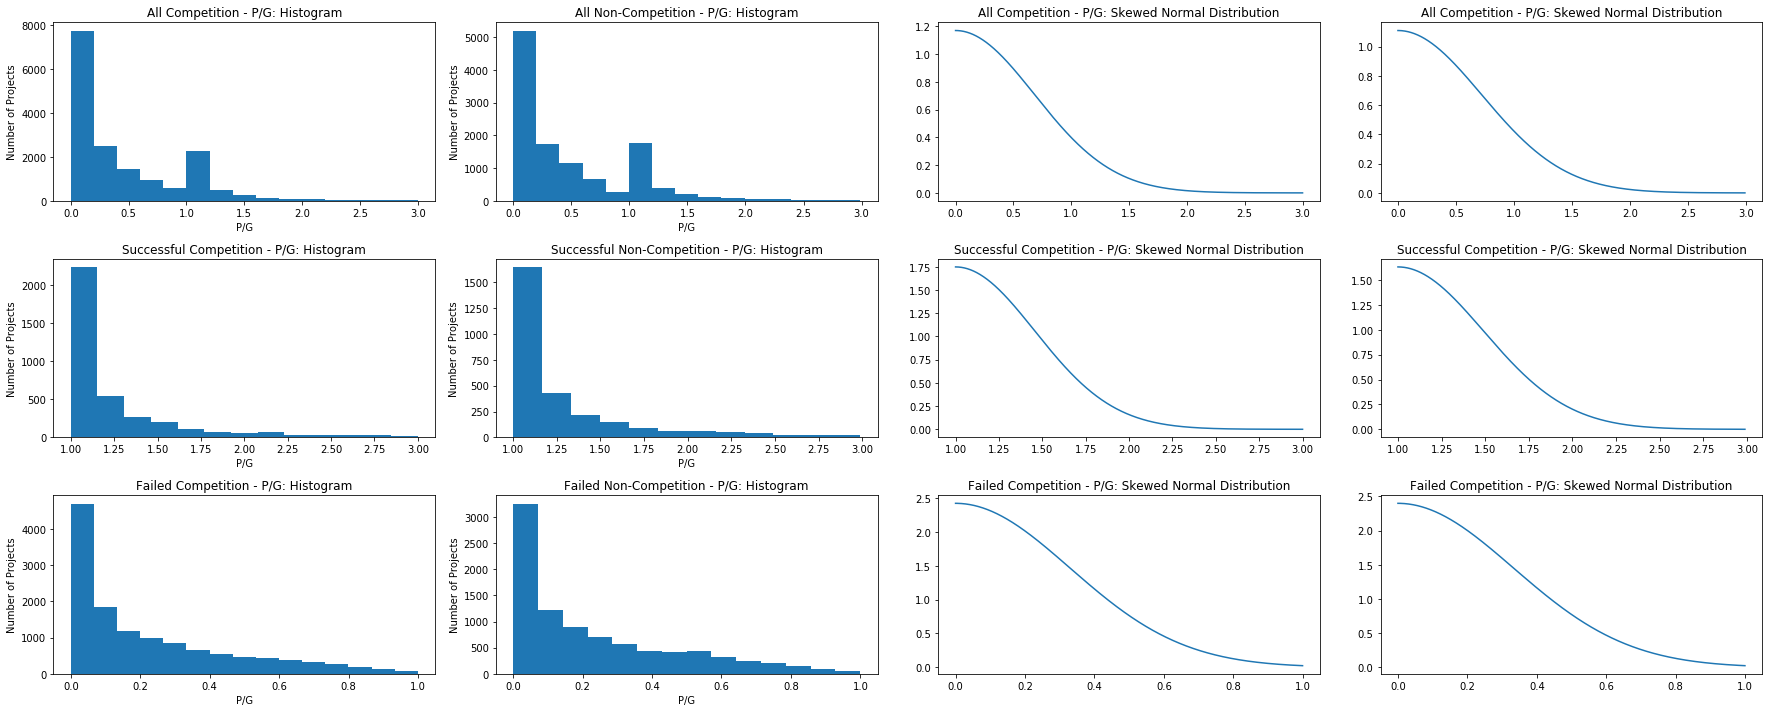

In [15]:
### P/G CI

print('All competitive vs. non-competitive projects P/G confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df_all_c['P/G']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_all_nc['P/G']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

print()
print('Successful competitive vs. non-competitive projects P/G confidence interval')
x5, x4, x6 = mean_confidence_interval(list(df_success_c['P/G']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df_success_nc['P/G']), 0.95)
print((x5, x4, x6))
print((y5, y4, y6))

print()
print('Failed competitive vs. non-competitive projects P/G confidence interval')
x8, x7, x9 = mean_confidence_interval(list(df_fail_c['P/G']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df_fail_nc['P/G']), 0.95)
print((x8, x7, x9))
print((y8, y7, y9))

fig1 = plt.figure(figsize = (4,12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects P/G confidence interval')
plt.ylabel('P/G')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (25,10))

plt.subplot(3,4,1)
new_lst = [i for i in list(df_all_c['P/G']) if i <= 3]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_all_nc['P/G']) if i <= 3]
plt.subplot(3,4,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - P/G: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Competition - P/G: Skewed Normal Distribution')

plt.subplot(3,4,5)
new_lst = [i for i in list(df_success_c['P/G']) if i <= 3]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_success_nc['P/G']) if i <= 3]
plt.subplot(3,4,6)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,7)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - P/G: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,8)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Competition - P/G: Skewed Normal Distribution')

plt.subplot(3,4,9)
new_lst = [i for i in list(df_fail_c['P/G'])]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_fail_nc['P/G'])]
plt.subplot(3,4,10)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,11)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - P/G: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,12)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Failed Competition - P/G: Skewed Normal Distribution')

plt.tight_layout()
plt.show()

All competitive vs. non-competitive projects duration confidence interval
(1.3678064816176, 1.3607025968174196, 1.3749103664177806)
(1.3794150556559577, 1.37107394726339, 1.3877561640485254)

Successful competitive vs. non-competitive projects duration confidence interval
(1.2637249811524438, 1.2493658297367554, 1.2780841325681322)
(1.2857372489858512, 1.2698948191804802, 1.3015796787912222)

Failed competitive vs. non-competitive projects duration confidence interval
(1.4016787119011904, 1.393583538657033, 1.4097738851453478)
(1.4151989049711708, 1.4054810055050218, 1.42491680443732)


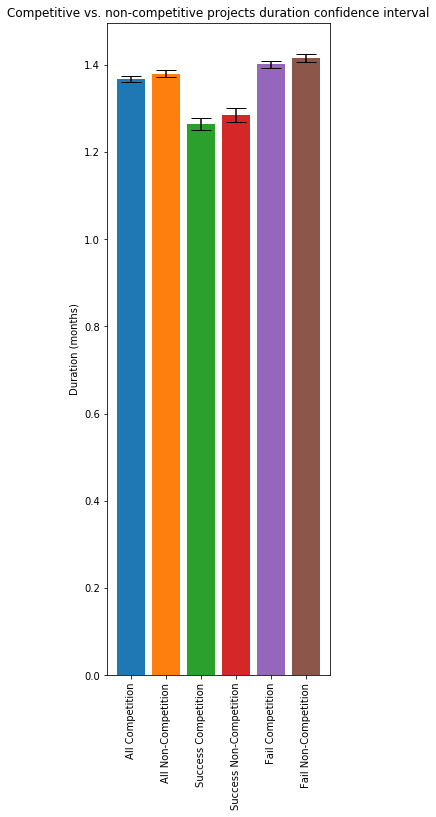

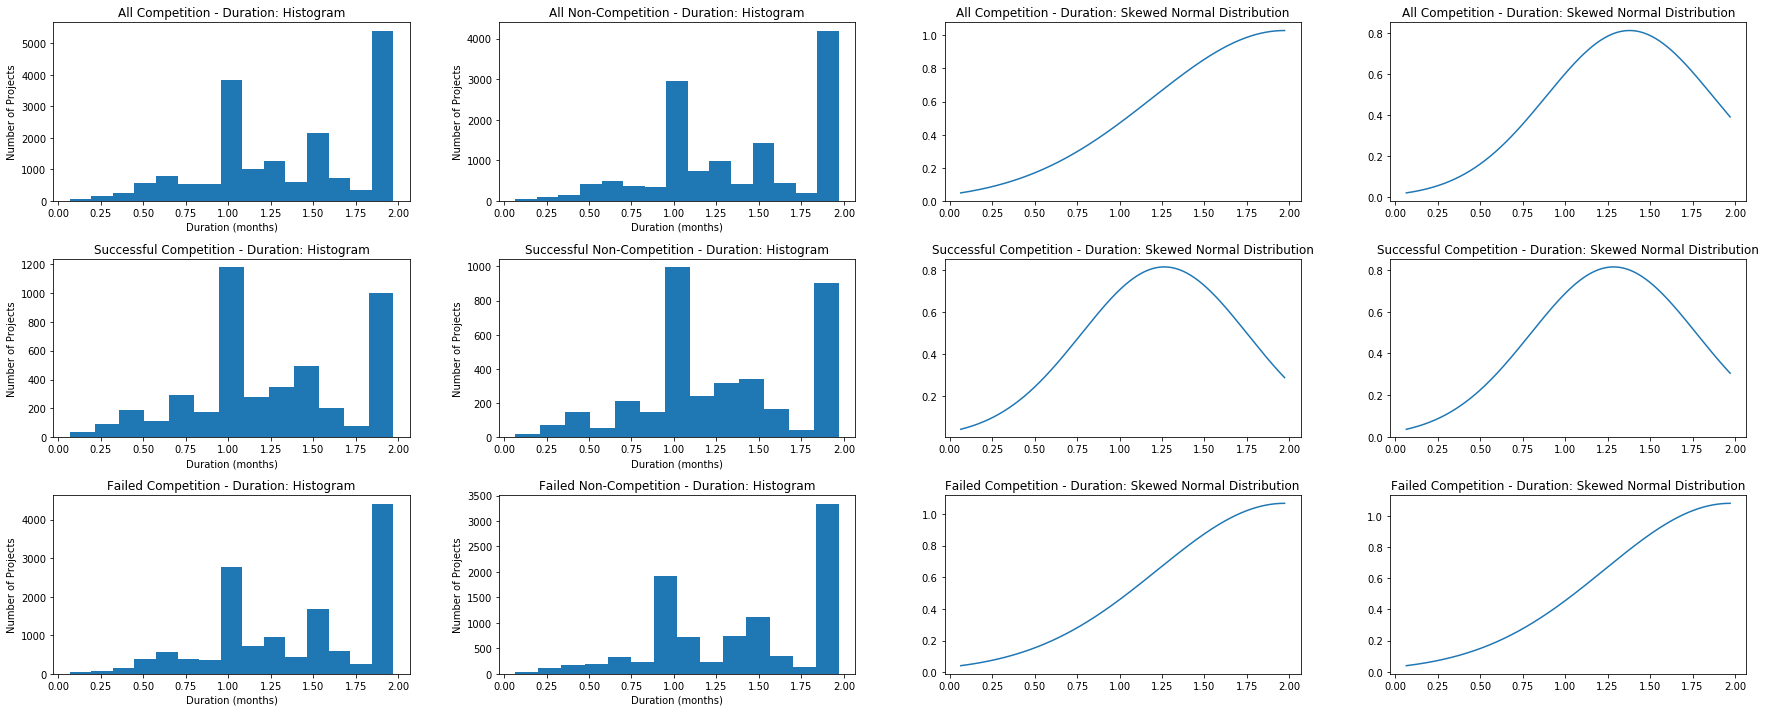

In [15]:
### Number of Duration CI

print('All competitive vs. non-competitive projects duration confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df_all_c['duration']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_all_nc['duration']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

print()
print('Successful competitive vs. non-competitive projects duration confidence interval')
x5, x4, x6 = mean_confidence_interval(list(df_success_c['duration']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df_success_nc['duration']), 0.95)
print((x5, x4, x6))
print((y5, y4, y6))

print()
print('Failed competitive vs. non-competitive projects duration confidence interval')
x8, x7, x9 = mean_confidence_interval(list(df_fail_c['duration']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df_fail_nc['duration']), 0.95)
print((x8, x7, x9))
print((y8, y7, y9))

fig1 = plt.figure(figsize = (4,12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects duration confidence interval')
plt.ylabel('Duration (months)')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (25,10))

plt.subplot(3,4,1)
new_lst = [i for i in list(df_all_c['duration']) if i<20]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_all_nc['duration']) if i<20]
plt.subplot(3,4,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - Duration: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Competition - Duration: Skewed Normal Distribution')

plt.subplot(3,4,5)
new_lst = [i for i in list(df_success_c['duration']) if i<20]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_success_nc['duration']) if i<20]
plt.subplot(3,4,6)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,7)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - Duration: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,8)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Competition - Duration: Skewed Normal Distribution')

plt.subplot(3,4,9)
new_lst = [i for i in list(df_fail_c['duration']) if i<20]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_fail_nc['duration']) if i<20]
plt.subplot(3,4,10)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(3,4,11)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - Duration: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(3,4,12)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Failed Competition - Duration: Skewed Normal Distribution')

plt.tight_layout()
plt.show()

In [17]:
### SAVE DATAFRAMES

df_all_c.to_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_competitiveprojects.pkl')
df_success_c.to_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_competitivesuccessprojects.pkl')
df_fail_c.to_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_competitivefailprojects.pkl')
df_all_nc.to_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_noncompetitiveprojects.pkl')
df_success_nc.to_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_noncompetitivesuccessprojects.pkl')
df_fail_nc.to_pickle('../Desktop/saved_dataframes/Store_indiegogo_subset_noncompetitivefailprojects.pkl')